# Solving a system of Ordinary Differential Equations (ODEs)
If you are not yet familiar with solving single ODEs with TFC, it is recommended you learn more about it via the [ODE TFC notebook](ODE.ipynb).

Consider the system of ODEs,

$$\ddot{y} = -4 z$$
$$\ddot{z} = 8z + 4y$$

where a double dot over the variable indicates the second derivative with respect to time, subject to the boundary constraints

$$ y(0) = -1 \quad y(3) = -e^6 \quad z(0) = 1 \quad \text{and} \quad z(3) = e^6$$

on the domain $t\in[0,3]$. The analytical solutions to these differntial equations are:

$$ y(t) = -e^{2t} $$
$$ z(t) = e^{2t} $$

To begin, let's create the univariate TFC class and create the analytical solution so we can compare against it later.

In [1]:
import jax.numpy as np
from tfc import utfc

# Create the univariate TFC class
N = 100 # Number of points in the domain
m = 30 # Degree of basis function expansion
nC = 2 # Indicates which basis functions need to be removed from the expansion

myTfc = utfc(N,nC,m,x0=0,xf=3)

# Create the analytical solutions
yReal = np.vectorize(lambda t: -np.exp(2.0*t))
zReal = np.vectorize(lambda t: np.exp(2.0*t))

The next step is to develop the constrained expressions,

$$ y(t,g^y(t)) = g^y(t) + \frac{3-t}{3}(-1 - g^y(0)) + \frac{t}{3}(-e^6 - g(3))$$
$$ z(t,g^z(t)) = g^z(t) + \frac{3-t}{3}(1 - g^z(0)) + \frac{t}{3}(e^6 - g(3))$$

In Python, we will use the Chebyshev orthogonal polynomials as the free-function, $g(t)$. In Python, we will use the same $g(t)$ function for each constrained expression, and pass in different unknowns.

In [2]:
t = myTfc.x # Collocation points from the TFC class

# Get the basis functions from the TFC class
H = myTfc.H

# Create the constrained expressions
g = lambda t,xi: np.dot(H(t),xi)
y = lambda t,xi_y: g(t,xi_y) + ((3.0-t)/3.0) * (-1.0 - g(np.zeros_like(t),xi_y)) + t/3.0 * (-np.exp(6.0)-g(3.0*np.ones_like(t),xi_y))
z = lambda t,xi_z: g(t,xi_z) + ((3.0-t)/3.0) * (1.0 - g(np.zeros_like(t),xi_z)) + t/3.0 * (np.exp(6.0)-g(3.0*np.ones_like(t),xi_z))

For a system of differential equations, we will use the same `NLLS` function as before to minimize the residuals of the differential equations. However, in this case, we have two sets of unkowns `xi_y` and `xi_z`. Moreover, we have two residuals. Therefore, we will combine the unknowns into a `TFCDict` and the residuals into a single function using `hstack`. The `TFCDict` functions much like a typically Python dictionary, but with a few operations overloaded that allow it to be used by the `NLLS` class. Moreover, it is registered as a known JAX type, so we can differentiate with respect to it if need be, much like a normal Python dictionary.

In [3]:
from tfc.utils import egrad, NLLS, TFCDict

# Create a TFCDict of the unknowns
xi0 = TFCDict({
    "xi_y": np.zeros(H(t).shape[1]),
    "xi_z": np.zeros(H(t).shape[1])
})

# Create the individual residuals
d2z = egrad(egrad(z))
d2y = egrad(egrad(y))

Ly = lambda t,xi: -d2y(t,xi["xi_y"]) - 4.0 * z(t,xi["xi_z"])
Lz = lambda t,xi: -d2z(t,xi["xi_z"]) + 8.0 * z(t,xi["xi_z"]) + 4.0 * y(t,xi["xi_y"])

# Combine the residuals into one function
L = lambda xi: np.hstack([Ly(t,xi), Lz(t,xi)])

# Minimize the residual using least-squares
xi,_,time = NLLS(xi0,L,timer=True)

Note that the last line in the above code block calls the JIT. Therefore, it may take a few seconds to run, because code is being compiled. However, once the code is finished compiling it runs very fast. The time returned by the `NLLS` function is the time it takes the compiled code to run, not the time it takes to compile the code itself. For more information on this function (and an associated class form) see the tutorial on [NLLS](NLLS.ipynb). 

Finally, lets compare the results to the true solution on a test set, and show some statistics about the TFC solution.

Run time: 0.02212349999999974
Maximum error on y: 1.7053025658242404e-13
Maximum error on z: 1.7053025658242404e-13


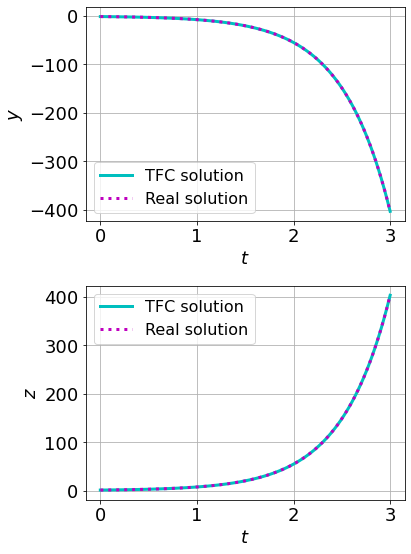

In [4]:
# Calculate the error on the test set
t_test = np.linspace(0.0, 3.0, 100)
errY = y(t_test,xi["xi_y"]) - yReal(t_test)
errZ = z(t_test,xi["xi_z"]) - zReal(t_test)

# Print out the results
print(f"Run time: {time}")
print(f"Maximum error on y: {np.max(np.abs(errY))}")
print(f"Maximum error on z: {np.max(np.abs(errY))}")

# Plot the results
from tfc.utils import MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline 
import matplotlib
matplotlib

p = MakePlot([r"$t$",r"$t$"],[r"$y$",r"$z$"])
p.ax[0].plot(t_test,y(t_test,xi["xi_y"]),label="TFC solution",color="c",linewidth=3)
p.ax[0].plot(t_test,yReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
p.ax[1].plot(t_test,z(t_test,xi["xi_z"]),label="TFC solution",color="c",linewidth=3)
p.ax[1].plot(t_test,zReal(t_test),label="Real solution",color="m",linestyle=":",linewidth=3)
for ax in p.ax:
    ax.legend()
    ax.grid()
p.PartScreen(6,8)
p.fig.tight_layout(w_pad=None)
p.show()

The difference between the TFC estimated solution and real solution is on the order of $10^{-13}$, and the TFC solution was obtained in just a few hundredths of a second.